# Анализ внедрения событий в продукт

In [1]:
import pandas as pd
import numpy as np
import statistics as st
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
palette = ["#ff6d69", "#b3e7dc", "#eff67b", "#24bee8", "#a6c64c", 
           "#ff5786", "#739c3e", "#7eb8da", "#ffa5d8", "#9579d1"]
sns.set_style("whitegrid")
sns.set_palette(palette)
import warnings
warnings.filterwarnings('ignore')

Возьмем данные активностей пользователей приложения. Допустим, было внедрено какое-либо событие(события) в определенный момент времени, например акции или скидки или добавление эксклюзивного материала. Попробуем понять как влияют события на покупательскую способность пользователя, проанализировав эффект всех событий на продукт, а так же по отдельности и сравнить влияние (т.е. определить какое событие было более эффективным).

In [2]:
# Загрузим данные
raw_data = pd.read_csv('ImitationData.csv')
raw_data['date'] =  pd.to_datetime(raw_data['date'], format='%Y-%m-%d')
data = raw_data

Таблица имеет следующий вид:

In [3]:
data.head()

,user_id,date,revenue,event_id,price
0,1,2019-11-19,50.788319,NaN,51.69
1,2,2019-11-19,49.590000,NaN,49.99
2,3,2019-11-19,0.000000,NaN,0.00
3,4,2019-11-19,49.088319,NaN,49.99
4,5,2019-11-19,9.798610,NaN,49.99


В таблице есть идентификатор пользователя, стоимость услуги, которую пользователь приобрел или не приобрел(в таком случае стоимость услуги и выручка равна нулю). Также есть поле даты активности, выручка(стоимость услуги минус налоги/сборы и т.д.) и поле идентификатора события. Всего событий 10. Так же одно событие может иметь разную цену для пользователя. Цена может зависеть, например от региона, комплектации предложения, привелегий клиента и т.д.

Если в поле события нет данных, то пользователь приобрел услугу независимо от события(событий), например не активировав его или не получив рассылку, и т.д.

In [4]:
# Уникальные события
data['event_id'].unique()

array([nan,  8.,  1.,  3.,  5.,  4.,  6.,  2., 10.,  7.,  9.])

Допустим, в период с 23 по 26 ноября происходило активное внедрение событий, например доступ к эксклюзивному материалу, который ранее было доступен малой доле потребителей

In [5]:
# Зададим границы дат
start, end = pd.to_datetime(["2019-11-23", "2019-11-26"], format='%Y-%m-%d')
data = data[(data['date'] >= start) & (data['date'] <= end)]

Имеем таблицу с данными с 23 по 26 ноября. Далее считаем метрики.

Рассчеты: 

Depositors - количество уникальных плательщиков

Deposits - сумма вкладов пользователей

ARPPU = Revenue / Depositors

Conversion rate = количество платежей во время событий/ общее число платежей * 100%

Avg Deposits per User = Deposits/количество транзакций

ARPU = Revenue / All Users

In [6]:
all_users = len(data["user_id"])

## Сравнение двух событий между собой

Посмотрим на два события, например на событие 5 и 6. Сравним эти события и сделаем вывод какое из этих событий является более эффективным. 

Функция подсчета метрик по событию

In [7]:
def calculation_KPIs_segment(event):
    
    # Кол-во юзеров, которые отреагировали на событие платежем
    Depositors = len(data[(data['event_id'] == event) & (data['price'] > 0)]['user_id'])
    
    # Сумма платежей
    Deposits = sum(data[data['event_id'] == event]['price'])
    
    # Сумма по полю Revenue
    Revenue = sum(data[data['event_id'] == event]['revenue'])
    
    ARPPU = Revenue / Depositors
    
    # Кол-во юзеров, которые воспользовались событием и внесли платеж / всех юзеров
    ConversRate = (Depositors / all_users)*100
    
    # Сумма платежей / кол-во заплативщих юзеров
    AvgDepPerUser = Deposits / Depositors
    
    # Доход по событию / доход по всем событиям 
    PercentRevenue = (Revenue / sum(data[pd.notnull(data["event_id"])]['revenue']))*100
    
    ARPU = Revenue/all_users
    
    # Формируем датафрейм, что бы занести в него результаты
    total = pd.DataFrame({'Depositors': Depositors, 'Deposits': Deposits, 'Revenue' : Revenue, 'ARPPU': ARPPU, 
                             'Conversion rate': ConversRate, 'Avg Deposits per User': AvgDepPerUser, 
                             '% of Revenue': PercentRevenue, 'ARPU': ARPU}, index=[0])
    return total

Посмотрим на результаты по метрикам для события 5

In [8]:
kpi_segment_first = calculation_KPIs_segment(5)
kpi_segment_first

,Depositors,Deposits,Revenue,ARPPU,Conversion rate,Avg Deposits per User,% of Revenue,ARPU
0,248,4931.22,4007.454409,16.15909,2.926599,19.883952,3.591447,0.472912


А так же для события 6

In [9]:
kpi_segment_second = calculation_KPIs_segment(6)
kpi_segment_second

,Depositors,Deposits,Revenue,ARPPU,Conversion rate,Avg Deposits per User,% of Revenue,ARPU
0,433,6449.47,5415.174479,12.506177,5.109747,14.89485,4.853034,0.639034


Работа функции показала, что событие 6 явилось более популярным, так как им воспользовалось больше пользователей. Соответственно метрики Deposits, Revenue, % of Revenue, ARPU и Conversion rate также выше чем для события 5. Средний платеж и ARPPU для события 5 больше, что говорит о том, что цена услуги для 5 события была выше чем для 6. Проверим так ли это. Посмотрим на распределения цен для ивентов:

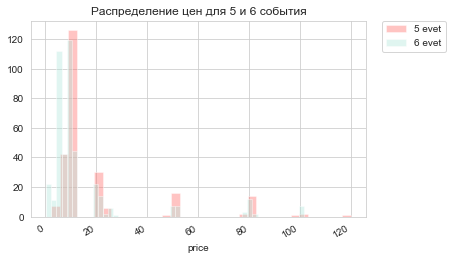

In [10]:
# Объединим выборку с событием 5 и событием 6 в один датафрейм.
first = data[(data['event_id'] == 5) & (data['price'] > 0)].reset_index()
second = data[(data['event_id'] == 6) & (data['price'] > 0)].reset_index()

first_and_second_events = pd.concat([first, second])

sns.distplot(first_and_second_events[first_and_second_events['event_id'] == 5]['price'],  kde=False, label='5 evet')
sns.distplot(first_and_second_events[first_and_second_events['event_id'] == 6]['price'],  kde=False, label='6 evet')
plt.gcf().autofmt_xdate()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Распределение цен для 5 и 6 события');

Распределение показало, что ценаы 5 ивента выше чем 6, но попробуем посмотреть на медианы. Среднее значение не смотрим, так как распределение цены не симметричное и медиана лучше характеризует среднее значение в этом случае.

In [11]:
print("Средняя стоимость для события 5 = ", 
      st.median(first_and_second_events[first_and_second_events['event_id'] == 5]['price']))
print("Средняя стоимость для события 6 = ", 
      st.median(first_and_second_events[first_and_second_events['event_id'] == 6]['price']))

Средняя стоимость для события 5 =  9.99
Средняя стоимость для события 6 =  9.99


Средняя стоимость для ивентов имеет одинаковую цену, следовательно метрику Avg Deposits per User и ARPPU анализируем следующим образов: диапазон цен для 5 ивента более расширен чем для 6, поэтому средний чек и выручка за платящего пользователя у 5 выше.
Посмотрим на диаграмму рассеяния:


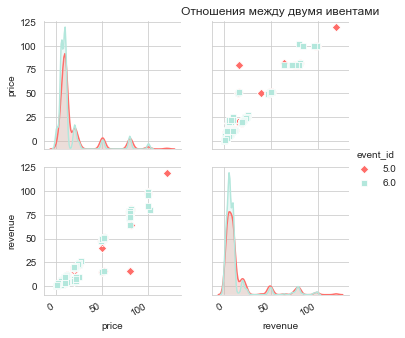

In [12]:
sns.pairplot(first_and_second_events, hue="event_id", vars = ['price', 'revenue'],
             markers=["D", "s"], palette=sns.color_palette(palette, 10))
plt.title('Отношения между двумя ивентами')
plt.gcf().autofmt_xdate()

Точечная диаграмма показывает, что данных для 6 ивента больше,что максимальный показатель по цене\выручке пренадлежит 5 ивенту. Также видна корреляция цены-выручки. На диагонали показаны графики плотности цен и выручки.

Далее посмотрим выручку по дням:

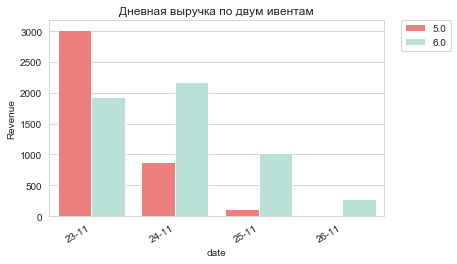

In [13]:
plt.figure()
ax = sns.barplot(data=first_and_second_events, x="date", y="revenue", hue="event_id", ci = None, estimator=sum)
ax.set_ylabel('Revenue')
ax.set_xticklabels(first_and_second_events['date'].dt.strftime('%d-%m').unique(), rotation='vertical')
plt.gcf().autofmt_xdate()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Дневная выручка по двум ивентам')
plt.show()

Видно, что вначале 5 ивент имел большую выручку, но далее убывал и 26 ноября вообще не приобрелся. Такую ситуацию следует изучить, возможно у пользователей были проблемы с доступом\неполадки на серере и т.д. Ивент 6 показывает лучший результат. Поэтому пока он более предпочтительней.

Далее посмотрим на box plot:

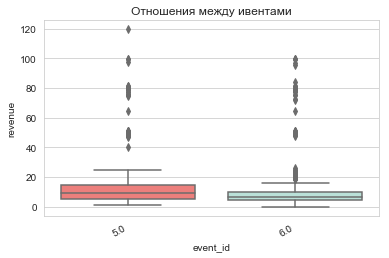

In [14]:
sns.boxplot(x="event_id", y="revenue", data=first_and_second_events)
plt.title('Отношения между ивентами')
plt.gcf().autofmt_xdate();

Сложно анализировать данный график из-за "выбросов" - очень больших отклонений от среднего. Попробуем очистить данные от слишком больших единичных платежей, что бы посмотреть усредненные показатели. Более подробней об очистке: https://www.geeksforgeeks.org/interquartile-range-to-detect-outliers-in-data/

Функция для очистки данных:

In [15]:
def outlier_hunt(my_data):

    # Detect and replace the outliers

    mean_data = np.nanmean(my_data, axis=0)
    Q1 = my_data.quantile(0.25)
    Q3 = my_data.quantile(0.75)
    IQR = (Q3 - Q1)*1.5
    index_detect_1 = np.where(my_data < Q1 - IQR)
    index_detect_2 = np.where(my_data > Q3 + IQR)
    index = np.concatenate((index_detect_1, index_detect_2), axis=1)
    for i in index:
        my_data[i] = mean_data
    return my_data

In [16]:
# Очищаем данные
first['revenue'] = outlier_hunt(first['revenue'])
second['revenue'] = outlier_hunt(second['revenue'])

new = pd.concat([first, second])

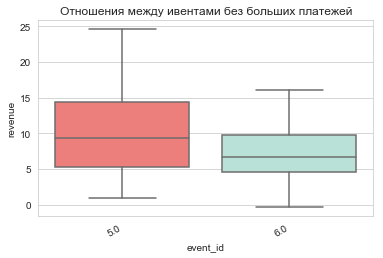

In [17]:
sns.boxplot(x="event_id", y="revenue", data=new)
plt.title('Отношения между ивентами без больших платежей')
plt.gcf().autofmt_xdate();

Имеем подтверждение вышеуказанным выводам. Видно, что медиана выручки у 5 ивента больше, а тек же диапазон смещен в более дорогостоящий сегмент.

Анализ метрик показал, что 6 событие более эффективно, так как в него было задействовано больше пользователей, следовательно, метрики монетизации были выше, кроме ARPPU. Но так же следует понять почему 5 событие было не так популярно и в последний день вообще не использовалось, возможно, недостаток рекламы, неактуальность предложения, дороговизна, проблемы с сервером и другие нюансы отталкивают пользователя. И в дальнейшем обновлении данное событие может стать более эффективным.

## Анализ всех событий за период

Функция подсчета метрик для всех событий

In [18]:
def calculation_KPIs_all():
    
    # Кол-во юзеров, которое отреагировали на события платежем
    Depositors = len(data[pd.notnull(data["event_id"]) & (data['price'] > 0)]['user_id'])
    
    # Суммирование платежей по всем событиям 
    Deposits = sum(data[pd.notnull(data["event_id"])]['price'])
    
    Revenue = sum(data[pd.notnull(data["event_id"])]['revenue'])
    
    ARPPU = Revenue / Depositors
    
    # Кол-во юзеров, которые воспользовались каким-либо событием / на всех юзеров
    ConversRate = (Depositors / all_users)*100
    
    AvgDepPerUser = Deposits / Depositors
    
    ARPU = Revenue/all_users
    
    total = pd.DataFrame({'Depositors': Depositors, 'Deposits': Deposits, 'Revenue' : Revenue, 'ARPPU': ARPPU, 
                          'Conversion rate': ConversRate, 'Avg Deposits per User': AvgDepPerUser,  'ARPU': ARPU}, index=[0])
    return total

Результаты функций для всех событий

In [19]:
kpi_all = calculation_KPIs_all()
kpi_all

,Depositors,Deposits,Revenue,ARPPU,Conversion rate,Avg Deposits per User,ARPU
0,5534,127429.86,111583.267818,20.163222,65.305641,23.026718,13.167721


Вывод результата показывает неплохие показатели, но для полноты оценки необходимо сравнить показатели до запуска и после. Так можно понять увеличили ли мы событиями монетизацию, или события никак не повлияли. Пока остановимся на данном результате и проанализируем все события.

Посмотрим на рафик популярности событий:

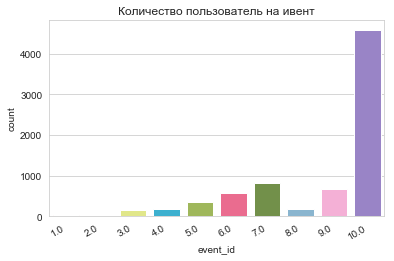

In [20]:
sns.countplot(data['event_id'])
plt.title('Количество пользователь на ивент')
plt.gcf().autofmt_xdate()

Видно, что самое популярное событие 10. Также собятия 1, 2, 3, 4 и 8 оказались с наименьшим количеством задействованнх пользователей. Далее посмотрим выручку на ивент:

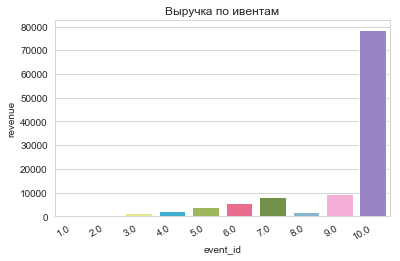

In [21]:
plt.figure()
ax = sns.barplot(data=data, x="event_id", y="revenue", ci = None, estimator=sum)
plt.gcf().autofmt_xdate()
plt.title('Выручка по ивентам')
plt.show()

Видно, что данный график соответствует графику популярности. Больше пользователей - больше и выручка.

Далее посмотрим на среднюю стоимость услуг по событиям:

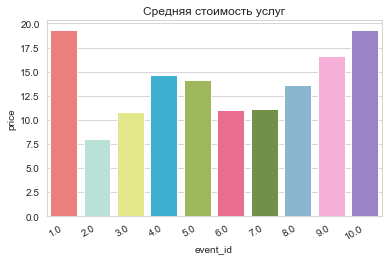

In [22]:
plt.figure()
ax = sns.barplot(data=data, x="event_id", y="price", ci = None)
plt.gcf().autofmt_xdate()
plt.title('Средняя стоимость услуг')
plt.show()

Данный график показывает, что вовлеченность пользователя не зависит от цены услуги, например событие 1 и событие 10 имеют одинаково высокую стоимость, но событие 10 является самым популярным и прибыльным; событие 2 имеет наименьшую стоимость, но оно не популярно. Тогда в данном случае можно сказать, что вовлеченность пользователей зависит от качества\наполнения события.

Далее посмотрим как пользователи покупали услуги по дням:

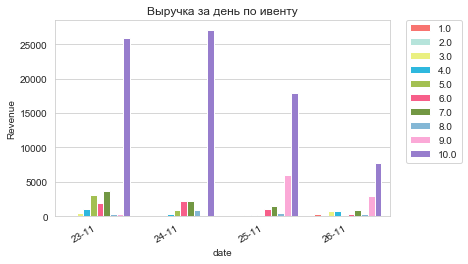

In [23]:
plt.figure()
ax = sns.barplot(data=data, x="date", y="revenue", hue="event_id", saturation=0.9, ci = None, estimator=sum)
ax.set_ylabel('Revenue')
ax.set_xticklabels(data['date'].dt.strftime('%d-%m').unique(), rotation='vertical')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Выручка за день по ивенту')
plt.gcf().autofmt_xdate()
plt.show()

Видно, что событие 10 имеет наибольшую выручку, но также присутствуют события, которые не использовались в какой-то день вообще. Следует это детальней уточнить, например, не было ли это проблемой сервера и т.д.

Ниже приведен аналогичный график линейного вида:

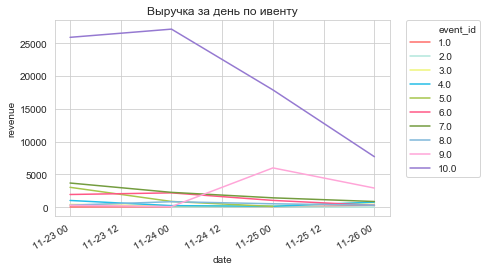

In [24]:
ax = sns.lineplot(x="date", y="revenue", hue="event_id",
                  data=data, legend = 'full', palette=sns.color_palette(palette, 10),
                  ci = None, estimator=sum)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Выручка за день по ивенту')
plt.gcf().autofmt_xdate()

Далее посмотрим на box plot:

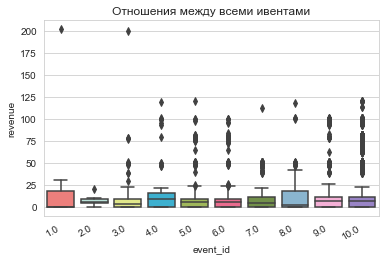

In [25]:
sns.boxplot(x="event_id", y="revenue", data=data)
plt.title('Отношения между всеми ивентами')
plt.gcf().autofmt_xdate();

Снова прибегнем к очистке данных для лучшей визуализации данных

In [26]:
# Очистка данных для анализа усредненных данных
event = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
data_without_outliers = []
for i in event:
    by_event = data[(data['event_id'] == i) & (data['price'] > 0)].reset_index()
    by_event['revenue'] = outlier_hunt(by_event['revenue'])
    data_without_outliers.append(by_event)
for_boxplot = pd.concat(data_without_outliers)

График на очищенных данных:

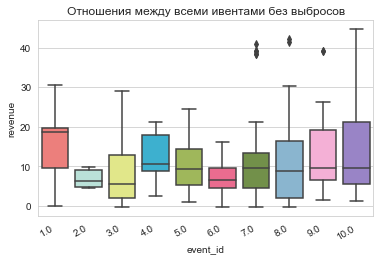

In [27]:
sns.boxplot(x="event_id", y="revenue", data=for_boxplot)
plt.title('Отношения между всеми ивентами без выбросов')
plt.gcf().autofmt_xdate();

Видно, что для 8, 9 и 10 событий медианы почти одинаковые, но максимальное значение у события 10. Также пользователи всегда покупали услуги событий 2, 4, 5, 9 и 10, так как, например, событие 1 имеет значение в нуле, что говорит о не покупке: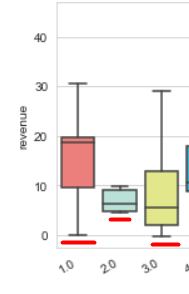

Посмотрим общий доход по дням:

In [28]:
# Посмотрим на доход по дням. Для этого проводим группировку по дате.
line_sum = pd.DataFrame(data.groupby(['date'])['revenue'].sum())
line_avg = pd.DataFrame(data.groupby(['date'])['revenue'].mean())

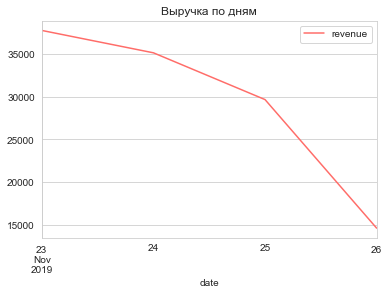

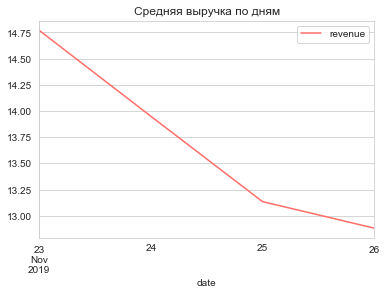

In [29]:
line_sum.plot(title = 'Выручка по дням', color = '#ff6d69');
line_avg.plot(title = 'Средняя выручка по дням', color = '#ff6d69');

Видно, что выручка убывает. Это может говорить о том, что основная масса пользователей сделала покупку в первый день старта событий. Но прерывное поведение событий говорит, что еще нужно сделать проверку на технические аспекты(сервер, доступ и т.д.)

# Анализ результата и постпокупательной активности

Для того, что бы проанализировать результат и постпокупательную активность неоходимо посмотреть данные платежей до начала событий и данные платежей после окончания событий. Так как события длились 4 дня проанализируем, например, 4 дня до начала событий и 4 дня после событий.

In [30]:
# Задаем интеравы
first_day_b, last_day_b = pd.to_datetime(["2019-11-19", "2019-11-22"], format='%Y-%m-%d')
first_day_a, last_day_a = pd.to_datetime(["2019-11-27", "2019-11-30"], format='%Y-%m-%d')

In [31]:
# Создаем отдельные фреймы для данных до и после событий
before_sales = raw_data[(raw_data['date'] >= first_day_b) & (raw_data['date'] <= last_day_b)]
after_sales = raw_data[(raw_data['date'] >= first_day_a) & (raw_data['date'] <= last_day_a)]

Посмотрим некоторые метрики:

Revenue

In [32]:
revenue_before = sum(before_sales['revenue'])
revenue_after = sum(after_sales['revenue'])
print('Выручка на 19, 20, 21, 22 ноября', revenue_before,
      '\nВыручка на 23, 24, 25, 26 ноября', kpi_all['Revenue'].loc[0],
      '\nВыручка на 27, 28, 29, 30 ноября', revenue_after)

Выручка на 19, 20, 21, 22 ноября 51437.16990750564 
Выручка на 23, 24, 25, 26 ноября 111583.26781793157 
Выручка на 27, 28, 29, 30 ноября 49773.388633843875


Виден прирост выручки во время событий, а также спад после. Это обусловлено, тем, что многие пользователи купили ресурс во время событий, а новый потребуеться ему через какое-то время.

Depositors

In [33]:
print('Платящих пользователей до событий:', len(before_sales[before_sales['price'] > 0]['user_id']), 
      '\nПлатящих пользователей во время событий:', kpi_all['Depositors'].loc[0],
      '\nПлатящих пользователей после событий:', len(after_sales[after_sales['price'] > 0]['user_id']))

Платящих пользователей до событий: 2655 
Платящих пользователей во время событий: 5534 
Платящих пользователей после событий: 2788


Видно, что во время событий пользователи совершали больше платежей. Но так же показатель метрики после событий выше чем до событий, хотя выручка меньше. Это говорит о том, что пользователи совершают менее дорогие покупки после событий чем до событий.

ARPPU

In [34]:
print('ARPPU before sales:', sum(before_sales['revenue'])/len(before_sales), 
      '\nARPPU during sales:', kpi_all['ARPPU'].loc[0],
      '\nARPPU after sales:', sum(after_sales['revenue'])/len(after_sales))

ARPPU before sales: 14.400103557532374 
ARPPU during sales: 20.163221506673576 
ARPPU after sales: 13.039923666189122


Метрика показывает, что внедрение событий положительно повлияло на продукт. Виден прирост метрики. После событий метрика убывает, что не странно после проведения акций, скидок и т.д. 

В целом имеем положительный результат. Внедрение событий показало прирост метрик монетизации. Так же следует уточнить не было ли проблем с серверов, так как некоторые события имели резкий спад или вовсе не использовались в какой-то день. Если технических проблем не было обнаружено, то такие непопулярные события в дальнейшем можно не использовать, а сконцентрироваться на прибыльных, улучшая и обновляя их.